# Building Multi-Agent Search-Draw System w/ AgentLite

AgentLite provides easy-to-use interface for building a multi-agent system. Following the steps as:
1. Defining the individual agents with actions
2. Defining the manager agent to control individual agents

Let's build a simple multi-agent search-plot system

In [1]:
import os
from agentlite.actions.BaseAction import BaseAction
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
import matplotlib.pyplot as plt

In [2]:
# define the drawFigure action
class DrawFigure(BaseAction):
    def __init__(self) -> None:
        action_name = "DrawFigure"
        action_desc = "Using this action to draw a bar figure for input statistics"
        params_doc = {"names": "the bar names. A list of names.", "values": "the bar value. A list of numbers." }
        super().__init__(
            action_name=action_name,
            action_desc=action_desc,
            params_doc=params_doc,
        )

    def __call__(self, names, values):
        plt.bar(names, values)
        plt.show()
        return "Successfully draw the bar figure!"


In [3]:
# define the wikipedia search action
class WikipediaSearch(BaseAction):
    def __init__(self) -> None:
        action_name = "Wikipedia_Search"
        action_desc = "Using this API to search Wiki content."
        params_doc = {"query": "the search string. be simple."}

        self.search = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
        super().__init__(
            action_name=action_name,
            action_desc=action_desc,
            params_doc=params_doc,
        )

    def __call__(self, query):
        return self.search.run(query)

In [4]:
from agentlite.agents import ABCAgent, BaseAgent
from agentlite.llm.agent_llms import BaseLLM, get_llm_backend
from agentlite.llm.LLMConfig import LLMConfig
from agentlite.logging.multi_agent_log import AgentLogger
from agentlite.commons import AgentAct, TaskPackage, ActObsChainType

# define the logger. You can set the PROMPT_DEBUG_FLAG=True to show the actual prompt and generation for LLM
agent_logger = AgentLogger(PROMPT_DEBUG_FLAG=False) 

# get the llm for agent
llm_config_dict = {"llm_name": "gpt-4-32k", "temperature": 0.0}
llm_config = LLMConfig(llm_config_dict)
llm = get_llm_backend(llm_config)

# define two individual agents
search_agent_info = {
    "name": "search_agent",
    "role": "you can search wikipedia to get the information."
}
search_agent = BaseAgent(name=search_agent_info["name"], 
                         role=search_agent_info["role"], 
                         llm=llm, 
                         actions=[WikipediaSearch()], 
                         logger=agent_logger)
plot_agent_info = {
    "name": "plot_agent",
    "role": "you can plot a bar figure based on the input names and values."
}
plot_agent = BaseAgent(name=plot_agent_info["name"],
                       role=plot_agent_info["role"],
                       llm=llm,
                       actions=[DrawFigure()],
                       logger=agent_logger)


In [5]:
# adding example to plot_agent to make it stable. 
from typing import List
from agentlite.actions import BaseAction
from agentlite.commons import AgentAct, TaskPackage
from agentlite.actions import ThinkAct, FinishAct
from agentlite.actions.InnerActions import INNER_ACT_KEY

exp_task = "plot a population figure for CityA and CityB, where CityA has 112.3 million people and CityB has 332.4 million people."
exp_task_pack = TaskPackage(instruction=exp_task)
act_1 = AgentAct(
    name=ThinkAct.action_name,
    params={
        INNER_ACT_KEY: f"I can use my action DrawFigure to plot a bar figure. The names parameter is ['CityA', 'CityB'] and values parameter is [112.3, 332.4]."
    },
)
obs_1 = "OK"
act_2 = AgentAct(
    name=DrawFigure().action_name,
    params={"names": ["CityA", "CityB"],
            "values": [112.3, 332.4]},
)
obs_2 = """Successfully draw the bar figure!"""
act_3 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "Done!"})
obs_3 = "Task Completed."
exp_act_obs = [(act_1, obs_1), (act_2, obs_2), (act_3, obs_3)]
plot_agent.add_example(
    task=exp_task_pack, action_chain=exp_act_obs
)


In [6]:
# define manager agent
from agentlite.agents import ManagerAgent

manager_agent_info = {
    "name": "manager_agent",
    "role": "you are controlling search_agent and plot_agent to complete the search and draw task."
}
team = [search_agent, plot_agent]
manager_agent = ManagerAgent(name=manager_agent_info["name"], role=manager_agent_info["role"], llm=llm, TeamAgents=team,logger=agent_logger)

In [9]:
# provide the example for manager agent. It is not required but highly suggested.
from agentlite.agents.agent_utils import AGENT_CALL_ARG_KEY
exp_task = "plot the bar figure of CityA and CityB population."
exp_task_pack = TaskPackage(instruction=exp_task)
act_1 = AgentAct(
    name=ThinkAct.action_name,
    params={
        INNER_ACT_KEY: f"""I fist need to ask {search_agent.name} to search the population of CityA and CityB. After I get the number. I should send the number to {plot_agent.name} to draw a bar figure."""
    },
)
obs_1 = "OK"
act_2 = AgentAct(
    name=search_agent.name,
    params={AGENT_CALL_ARG_KEY: "Can you find the population of CityA and CityB?" }
)
obs_2 = "The population of CityA is approximately 112.3 million and the population of CityB is approximately 332.4 million."
act_3 = AgentAct(
    name=ThinkAct.action_name,
    params={
        INNER_ACT_KEY: f"""I have already find the value of CityA and CityB, which are 112.3 million and 332.4 million respectively. I now should ask {plot_agent.name} to draw a bar figure."""
    },
)
obs_3 = "OK"
act_4 = AgentAct(
    name=plot_agent.name,
    params={AGENT_CALL_ARG_KEY: "draw a bar figure for the population of CityA and CityB, and the values are 112.3 and 332.4 respectively."}
)
obs_4 = """Done!"""
act_5 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "I have successfully find the population of CityA and CityB and plot the bar figure."})
obs_5 = "Task Completed."
exp_act_obs = [(act_1, obs_1), (act_2, obs_2), (act_3, obs_3), (act_4, obs_4)]
manager_agent.add_example(
    task=exp_task_pack, action_chain=exp_act_obs
)


Agent manager_agent receives the following TaskPackage:
[
	Task ID: 2ac56746-f231-4ef6-ac81-582b54ad90df
	Instruction: plot the bar figure of California and Mexico population.
]
====manager_agent starts execution on TaskPackage 2ac56746-f231-4ef6-ac81-582b54ad90df====
Agent manager_agent takes 0-step Action:
{
	name: Think
	params: {'response': 'I first need to ask search_agent to search the population of California and Mexico. After I get the number. I should send the number to plot_agent to draw a bar figure.'}
}
Observation: OK
Agent manager_agent takes 1-step Action:
{
	name: search_agent
	params: {'Task': 'Can you find the population of California and Mexico?'}
}
Agent search_agent receives the following TaskPackage:
[
	Task ID: 2ac56746-f231-4ef6-ac81-582b54ad90df
	Instruction: Can you find the population of California and Mexico?
]
====search_agent starts execution on TaskPackage 2ac56746-f231-4ef6-ac81-582b54ad90df====
Agent search_agent takes 0-step Action:
{
	name: Think
	par

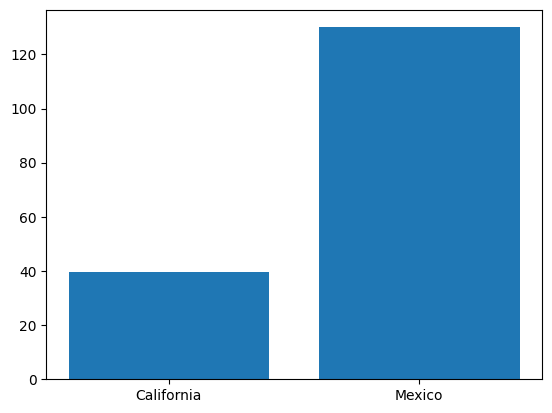

Observation: Successfully draw the bar figure!
Agent plot_agent takes 1-step Action:
{
	name: Finish
	params: {'response': 'Task completed!'}
}
Observation: Task Completed.
=========plot_agent finish execution. TaskPackage[ID:2ac56746-f231-4ef6-ac81-582b54ad90df] status:
[
	completion: completed
	answer: Task completed!
]
Observation: Task completed!
Agent manager_agent takes 4-step Action:
{
	name: Finish
	params: {'response': 'The bar figure has been successfully drawn.'}
}
Observation: Task Completed.
=========manager_agent finish execution. TaskPackage[ID:2ac56746-f231-4ef6-ac81-582b54ad90df] status:
[
	completion: completed
	answer: The bar figure has been successfully drawn.
]
The bar figure has been successfully drawn.


In [10]:
# run test
test_task = "plot the bar figure of California and Mexico population."
test_task_pack = TaskPackage(instruction=test_task, task_creator="User")
response = manager_agent(test_task_pack)
print(response)